ℹ️ Fichier TA sélectionné : ta_btcusdc_1h_365d_250524.parquet
Loaded 8,711 rows from ta_btcusdc_1h_365d_250524.parquet
Plotting 62 rows from 2024-05-26 10:00:00+00:00 to 2024-05-28 23:00:00+00:00


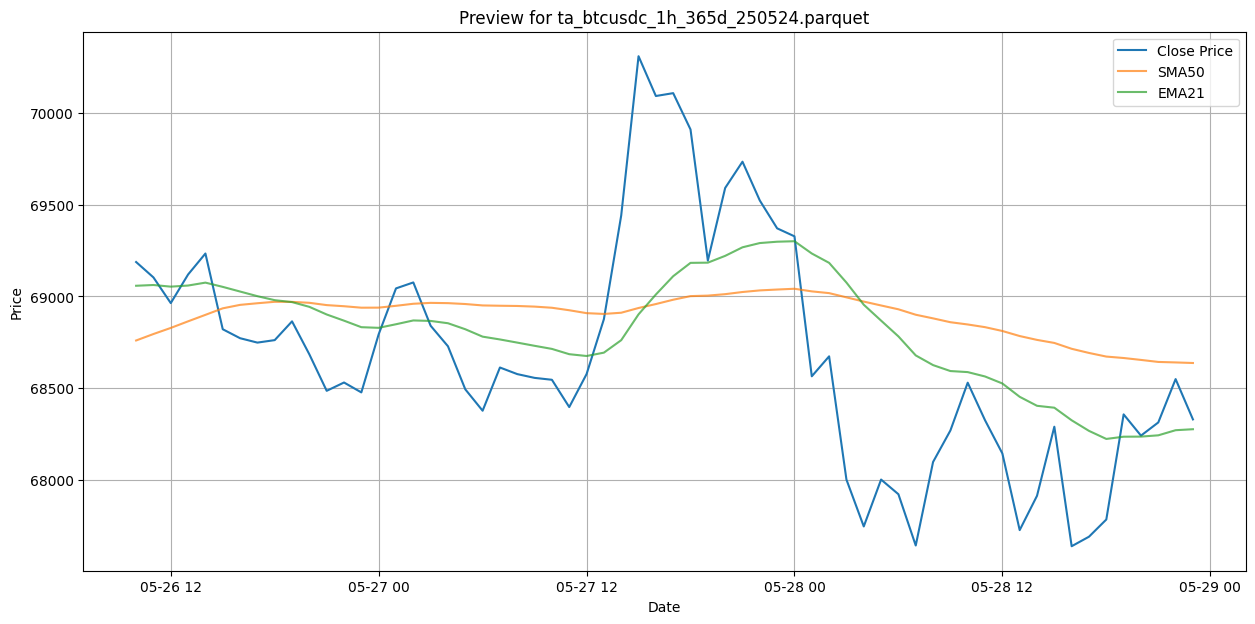

In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
# from datetime import datetime # Plus nécessaire si on utilise pd.to_datetime pour les dates de filtrage
import glob # Pour scanner les fichiers

# --- User Editable Parameters ---
SYMBOL       = "btcusdc"     # Ex: "btcusdc", "ethusdt". Doit correspondre au début du nom de fichier.
INTERVAL     = "1h"            # Ex: "1m", "15m", "1h", "1d".
DAYS_DURATION= "365d"         # Ex: "365d", "90d". Doit correspondre à la partie durée du fichier.

# Date de génération spécifique (YYMMDD) si vous voulez un fichier précis.
# Laissez None pour prendre le plus récent correspondant à SYMBOL, INTERVAL, DAYS_DURATION.
SPECIFIC_GEN_DATE = None       # Ex: "240528" or None

START_DATE_FILTER = "2024-05-01" # Format YYYY-MM-DD. Laissez None pour ne pas filtrer par début.
END_DATE_FILTER   = "2024-05-28"   # Format YYYY-MM-DD. Laissez None pour ne pas filtrer par fin.
ROWS_LIMIT        = None           # Ex: 1000 pour afficher les N dernières lignes, ou None pour tout.

# --------------------------------
DATA_DIR = Path("..") / "data" # Ajustez si votre notebook est ailleurs (ex: Path("data"))

# --- Trouver le fichier TA ---
# Construire un motif de recherche
# Le motif sera quelque chose comme: ta_btcusdc_1h_365d_*.parquet
# ou ta_btcusdc_1h_365d_240528.parquet si SPECIFIC_GEN_DATE est fourni

if SPECIFIC_GEN_DATE:
    file_pattern_name = f"ta_{SYMBOL.lower()}_{INTERVAL}_{DAYS_DURATION}_{SPECIFIC_GEN_DATE}.parquet"
    ta_files_found = list(DATA_DIR.glob(file_pattern_name))
else:
    file_pattern_name = f"ta_{SYMBOL.lower()}_{INTERVAL}_{DAYS_DURATION}_??????.parquet" # ?????? pour YYMMDD
    ta_files_found = sorted(list(DATA_DIR.glob(file_pattern_name)), reverse=True) # Trier pour avoir le plus récent en premier

if not ta_files_found:
    print(f"❌ Aucun fichier TA trouvé pour le motif : {DATA_DIR / file_pattern_name}")
    print("Veuillez vérifier les paramètres SYMBOL, INTERVAL, DAYS_DURATION et SPECIFIC_GEN_DATE,")
    print("et assurez-vous que le script indicators.py a été exécuté.")
    # Pour arrêter l'exécution du notebook si aucun fichier n'est trouvé, vous pouvez décommenter :
    # raise FileNotFoundError(f"Aucun fichier TA trouvé pour le motif : {DATA_DIR / file_pattern_name}")
    TA_FILE = None # ou une valeur qui fera échouer la suite proprement
else:
    TA_FILE = ta_files_found[0] # Prendre le premier (le plus récent si non spécifique, ou le seul si spécifique)
    print(f"ℹ️ Fichier TA sélectionné : {TA_FILE.name}")


# --- Chargement et préparation des données ---
if TA_FILE and TA_FILE.exists():
    df = pd.read_parquet(TA_FILE)
    
    # S'assurer que 'open_dt' est au format datetime (les fichiers TA devraient déjà l'avoir)
    if 'open_dt' in df.columns:
        df['open_dt'] = pd.to_datetime(df['open_dt'], errors='coerce', utc=True)
    elif 'open_time' in df.columns: # Fallback si 'open_dt' n'existe pas mais 'open_time' oui
        df['open_dt'] = pd.to_datetime(df['open_time'], unit='ms', utc=True)
        print("  Colonne 'open_dt' créée à partir de 'open_time'.")
    else:
        print("❌ Colonnes 'open_dt' ou 'open_time' non trouvées dans le fichier.")
        df = pd.DataFrame() # Créer un DataFrame vide pour éviter les erreurs suivantes

    if not df.empty:
        print(f"Loaded {len(df):,} rows from {TA_FILE.name}")

        # --- Filtrage des données ---
        if START_DATE_FILTER:
            start_ts = pd.to_datetime(START_DATE_FILTER, utc=True)
            df = df[df['open_dt'] >= start_ts]
        if END_DATE_FILTER:
            # Pour inclure la journée entière de END_DATE_FILTER, on peut aller jusqu'à la fin de cette journée
            end_ts = pd.to_datetime(END_DATE_FILTER, utc=True) + pd.Timedelta(days=1) - pd.Timedelta(milliseconds=1)
            # Ou plus simple si on compare juste les dates (nécessite .dt.date ou .normalize())
            # end_ts_date = pd.to_datetime(END_DATE_FILTER).date()
            # df = df[df['open_dt'].dt.date <= end_ts_date]
            df = df[df['open_dt'] <= end_ts]

        if ROWS_LIMIT and isinstance(ROWS_LIMIT, int) and ROWS_LIMIT > 0:
            df = df.tail(ROWS_LIMIT)

        if not df.empty:
            print(f"Plotting {len(df):,} rows from {df['open_dt'].min()} to {df['open_dt'].max()}")
            
            # --- Section de tracé (à ajouter ici si nécessaire) ---
            # Exemple simple (à adapter avec vos colonnes d'indicateurs)
            if 'close' in df.columns and 'open_dt' in df.columns:
                plt.figure(figsize=(15, 7))
                plt.plot(df['open_dt'], df['close'], label='Close Price')
                
                if 'sma50' in df.columns:
                    plt.plot(df['open_dt'], df['sma50'], label='SMA50', alpha=0.7)
                if 'ema21' in df.columns:
                    plt.plot(df['open_dt'], df['ema21'], label='EMA21', alpha=0.7)
                
                plt.title(f"Preview for {TA_FILE.name}")
                plt.xlabel("Date")
                plt.ylabel("Price")
                plt.legend()
                plt.grid(True)
                plt.show()
            else:
                print("ℹ️ Colonnes 'open_dt' ou 'close' manquantes pour le tracé.")
        else:
            print("ℹ️ Aucune donnée à afficher après filtrage.")
    else:
        print(f"ℹ️ Le fichier {TA_FILE.name} est vide ou n'a pas pu être chargé correctement.")

else:
    if TA_FILE is None: # Déjà géré par le message d'erreur de recherche de fichier
        pass
    else: # TA_FILE a été défini mais .exists() est faux (ne devrait pas arriver avec glob)
        print(f"❌ Le fichier TA {TA_FILE} a été identifié mais n'existe pas.")

## Moyenne Mobile Simple (SMA)
- **Définition** : La SMA est la moyenne arithmétique des prix de clôture d’un actif sur une période donnée (ex. 10, 50, 200 jours). Chaque point est calculé en additionnant les prix de clôture sur la période et en divisant par le nombre de périodes.
- **Utilisation** : Elle sert à lisser les fluctuations des prix pour identifier la tendance générale. Si le prix est au-dessus de la SMA, cela indique souvent une tendance haussière, en dessous une tendance baissière. La période choisie dépend de l’horizon de trading (court, moyen, long terme).
- **Pourquoi** : Simple à calculer et à interpréter, elle aide à détecter les niveaux de support/résistance et les retournements potentiels.

## Moyenne Mobile Exponentielle (EMA)
- **Définition** : L’EMA est une moyenne mobile qui donne plus de poids aux prix récents, ce qui la rend plus réactive que la SMA.
- **Utilisation** : Utilisée pour capter plus rapidement les changements de tendance. Souvent utilisée en croisement (ex. EMA 50 et EMA 200) pour générer des signaux d’achat ou de vente (croisement haussier ou baissier). Elle peut aussi servir de support ou résistance dynamique dans une tendance.
- **Pourquoi** : Moins de retard que la SMA, donc meilleure pour les stratégies de trading à court terme et pour confirmer le momentum avec d’autres indicateurs comme le RSI.

## Indice de Force Relative (RSI)
- **Définition** : Le RSI est un oscillateur de momentum mesurant la vitesse et l’ampleur des variations de prix récentes, exprimé entre 0 et 100.
- **Utilisation** : Il identifie les situations de surachat (RSI > 70) ou de survente (RSI < 30) pour anticiper des retournements. Les divergences entre RSI et prix peuvent signaler des inversions de tendance.
- **Pourquoi** : Permet de détecter des excès dans le mouvement des prix et de prévoir des corrections ou rebonds.

## MACD (Moving Average Convergence Divergence)
- **Définition** : Le MACD est un indicateur de tendance basé sur la différence entre deux EMA (généralement 12 et 26 périodes) et une ligne de signal (EMA de la différence).
- **Utilisation** : Il génère des signaux d’achat/vente par les croisements entre la ligne MACD et la ligne de signal. Les divergences entre MACD et prix indiquent des retournements potentiels. L’histogramme montre la force du momentum.
- **Pourquoi** : Combine la tendance et le momentum pour fournir des signaux clairs d’entrée/sortie sur le marché.

## Bandes de Bollinger
- **Définition** : Les bandes de Bollinger sont constituées d’une moyenne mobile (souvent SMA 20) entourée de deux bandes situées à deux écarts-types au-dessus et en dessous de cette moyenne.
- **Utilisation** : Elles mesurent la volatilité du marché. Lorsque les prix touchent la bande supérieure, l’actif est potentiellement suracheté, et lorsqu’ils touchent la bande inférieure, il est potentiellement survendu. La contraction des bandes annonce souvent une forte volatilité à venir.
- **Pourquoi** : Aide à identifier les phases de consolidation, les ruptures de tendance et les niveaux extrêmes du prix.

## Average True Range (ATR)
- **Définition** : L’ATR est un indicateur de volatilité qui mesure la variation moyenne des prix d’un actif sur une période donnée, en tenant compte des écarts (gaps) entre les sessions. Il est calculé comme la moyenne mobile des “True Range”, où le True Range est le plus grand des écarts suivants : haut du jour - bas du jour, valeur absolue du haut du jour - clôture précédente, valeur absolue du bas du jour - clôture précédente.
- **Utilisation** : L’ATR sert à évaluer la volatilité du marché indépendamment de la direction du prix. Il est couramment utilisé pour ajuster dynamiquement les stop loss et la taille des positions, en fonction de la volatilité actuelle. Une ATR élevée indique une forte volatilité, une ATR basse signale une période calme ou de consolidation.
- **Pourquoi** : Permet une gestion du risque plus adaptée en tenant compte des fluctuations réelles du marché, évitant ainsi des stops trop serrés ou trop larges. Il aide aussi à confirmer des cassures ou des mouvements significatifs en détectant les changements de volatilité[1][2][5][8].

# Idées de stratégies : 
- Acheter quand le cours croise à la haute la SMA 50 en vérifiant que la EMA 21 < SMA 50 puis vendre quand le cours croise à la baise la EMA 21 lorsque EMA 21 > SMA 50

ℹ️ Fichier TA sélectionné : ta_btcusdc_1h_365d_250524.parquet
Loaded 8,711 rows from ta_btcusdc_1h_365d_250524.parquet
  Données filtrées. Affichage de 62 lignes.
Plotting 62 rows from 2024-05-26 10:00 to 2024-05-28 23:00


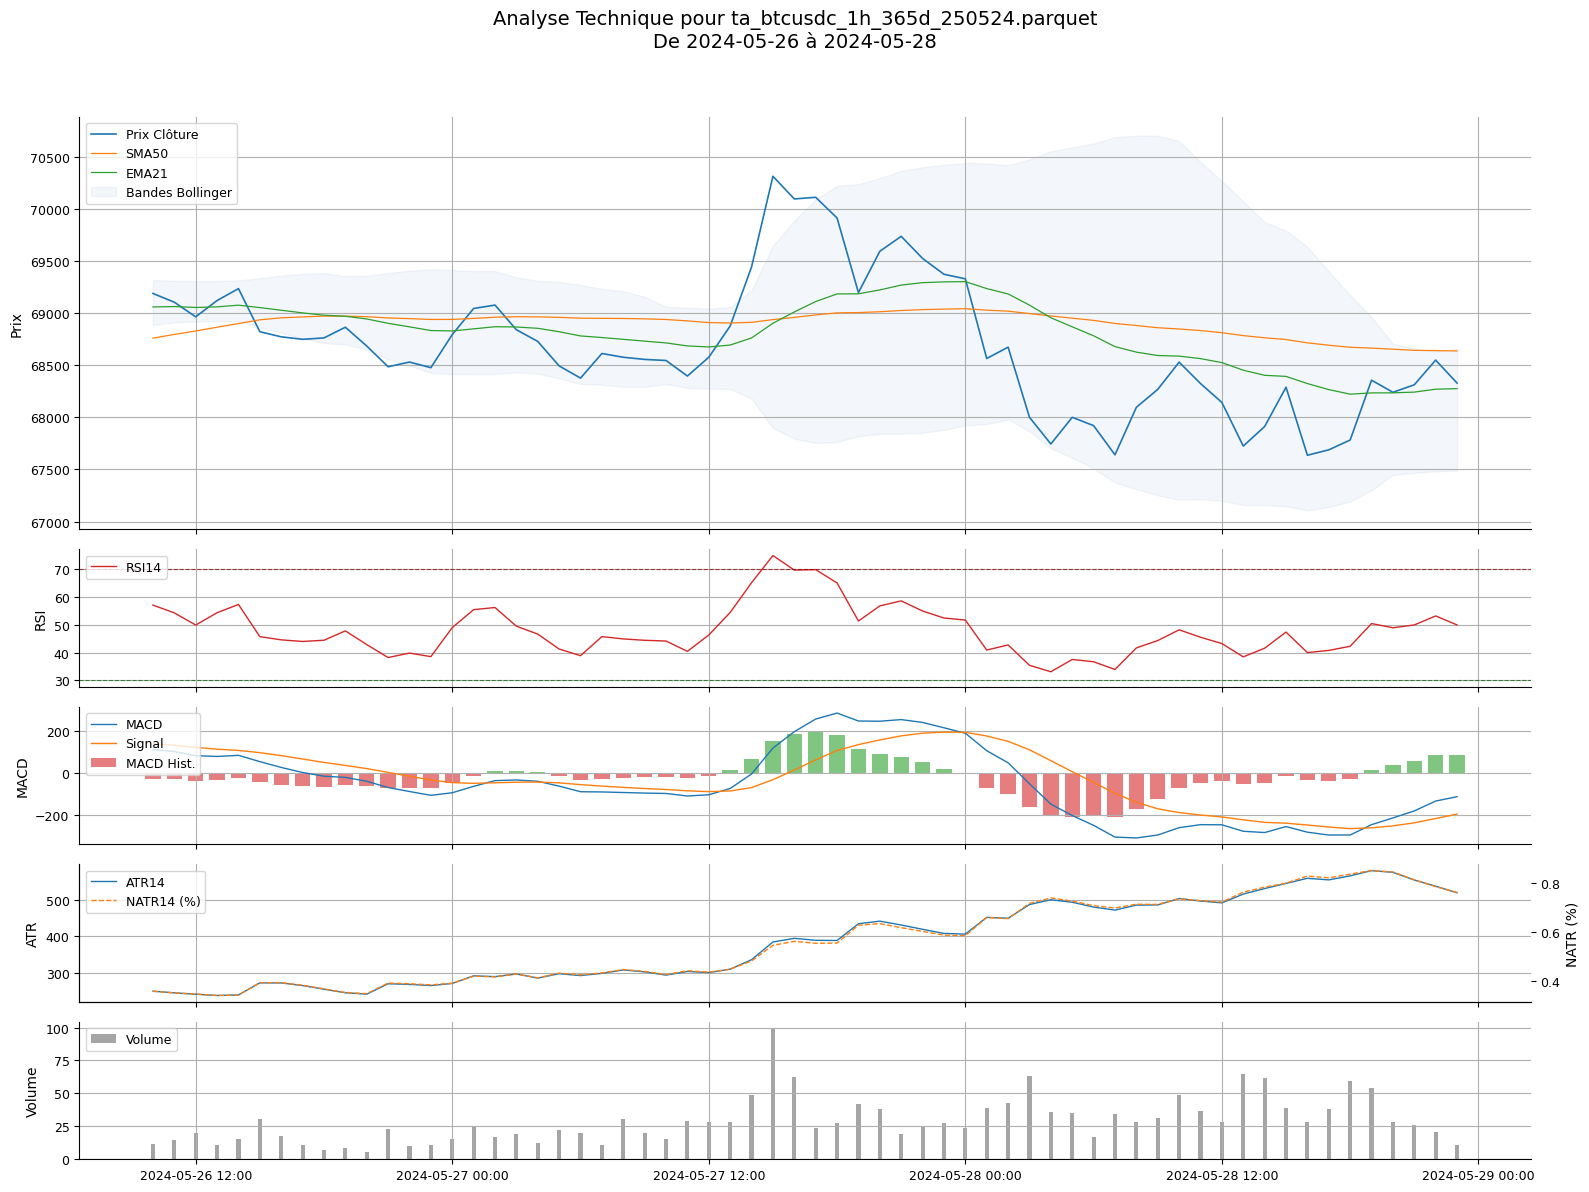

In [2]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates # Utile pour le formatage des dates sur l'axe X
import glob # Pour scanner les fichiers

# --- User Editable Parameters ---
SYMBOL       = "btcusdc"     # Ex: "btcusdc", "ethusdt". Doit correspondre au début du nom de fichier.
INTERVAL     = "1h"            # Ex: "1m", "15m", "1h", "1d".
DAYS_DURATION= "365d"         # Ex: "365d", "90d". Doit correspondre à la partie durée du fichier.

# Date de génération spécifique (YYMMDD) si vous voulez un fichier précis.
# Laissez None pour prendre le plus récent correspondant à SYMBOL, INTERVAL, DAYS_DURATION.
SPECIFIC_GEN_DATE = None       # Ex: "240528" or None

START_DATE_FILTER = "2024-05-01" # Format YYYY-MM-DD. Laissez None pour ne pas filtrer par début.
END_DATE_FILTER   = "2024-05-28"   # Format YYYY-MM-DD. Laissez None pour ne pas filtrer par fin.
ROWS_LIMIT        = None           # Ex: 1000 pour afficher les N dernières lignes, ou None pour tout.

# --------------------------------
# Ajustez DATA_DIR si votre notebook est dans un sous-dossier comme 'notebooks/'
# Si le notebook est dans S2/notebooks/ et data est dans data/ à la racine du projet:
# DATA_DIR = Path("../../data")
# Si le notebook est dans S2/ et data est dans data/
DATA_DIR = Path("../data")
# Si le notebook est à la racine du projet et data est dans data/
# DATA_DIR = Path("data")


# --- Trouver le fichier TA ---
if SPECIFIC_GEN_DATE:
    file_pattern_name = f"ta_{SYMBOL.lower()}_{INTERVAL}_{DAYS_DURATION}_{SPECIFIC_GEN_DATE}.parquet"
    ta_files_found = list(DATA_DIR.glob(file_pattern_name))
else:
    file_pattern_name = f"ta_{SYMBOL.lower()}_{INTERVAL}_{DAYS_DURATION}_??????.parquet"
    ta_files_found = sorted(list(DATA_DIR.glob(file_pattern_name)), reverse=True)

if not ta_files_found:
    print(f"❌ Aucun fichier TA trouvé pour le motif : {DATA_DIR / file_pattern_name}")
    print("Veuillez vérifier les paramètres SYMBOL, INTERVAL, DAYS_DURATION et SPECIFIC_GEN_DATE,")
    print("et assurez-vous que le script indicators.py a été exécuté.")
    TA_FILE = None
else:
    TA_FILE = ta_files_found[0]
    print(f"ℹ️ Fichier TA sélectionné : {TA_FILE.name}")

# --- Chargement et préparation des données ---
df = pd.DataFrame() # Initialiser df comme un DataFrame vide
if TA_FILE and TA_FILE.exists():
    df_temp = pd.read_parquet(TA_FILE) # Charger dans un df temporaire
    
    if 'open_dt' in df_temp.columns:
        df_temp['open_dt'] = pd.to_datetime(df_temp['open_dt'], errors='coerce', utc=True)
    elif 'open_time' in df_temp.columns:
        df_temp['open_dt'] = pd.to_datetime(df_temp['open_time'], unit='ms', utc=True)
        print("  Colonne 'open_dt' créée à partir de 'open_time'.")
    else:
        print("❌ Colonnes 'open_dt' ou 'open_time' non trouvées dans le fichier.")
        # df reste vide

    if not df_temp.empty and 'open_dt' in df_temp.columns and not df_temp['open_dt'].isnull().all():
        df = df_temp # Assigner à df principal seulement si valide
        print(f"Loaded {len(df):,} rows from {TA_FILE.name}")

        # --- Filtrage des données ---
        original_row_count = len(df)
        if START_DATE_FILTER:
            start_ts = pd.to_datetime(START_DATE_FILTER, utc=True)
            df = df[df['open_dt'] >= start_ts].copy() # Utiliser .copy() pour éviter SettingWithCopyWarning
        if END_DATE_FILTER:
            end_ts = pd.to_datetime(END_DATE_FILTER, utc=True) + pd.Timedelta(days=1) - pd.Timedelta(milliseconds=1)
            df = df[df['open_dt'] <= end_ts].copy()

        if ROWS_LIMIT and isinstance(ROWS_LIMIT, int) and ROWS_LIMIT > 0:
            df = df.tail(ROWS_LIMIT).copy()
        
        if len(df) < original_row_count and len(df) > 0:
            print(f"  Données filtrées. Affichage de {len(df):,} lignes.")
        elif len(df) == 0 and original_row_count > 0:
            print(f"  Aucune donnée restante après filtrage pour la période : {START_DATE_FILTER} à {END_DATE_FILTER}.")

    elif not df_temp.empty: # df_temp a été chargé mais n'a pas de colonne de date valide
        print(f"ℹ️ Le fichier {TA_FILE.name} a été chargé mais la colonne 'open_dt' est invalide ou manquante.")
    # else: df_temp était vide au départ, géré par la condition suivante

# --- Tracé des indicateurs (si df n'est pas vide) ---
if not df.empty:
    print(f"Plotting {len(df):,} rows from {df['open_dt'].min():%Y-%m-%d %H:%M} to {df['open_dt'].max():%Y-%m-%d %H:%M}")

    # <<< VOTRE CODE DE TRACÉ INTÉGRÉ ICI >>>
    plt.style.use('default') # Ou un autre style que vous préférez, ex: 'seaborn-v0_8-darkgrid'
    plt.rcParams.update({
        'figure.figsize': (16, 12), # Ajusté pour 5 subplots
        'axes.grid': True,
        'axes.spines.top': False,
        'axes.spines.right': False,
        'font.family': 'sans-serif', # Optionnel, pour la cohérence
        'axes.labelsize': 10,
        'axes.titlesize': 12,
        'xtick.labelsize': 9,
        'ytick.labelsize': 9,
        'legend.fontsize': 9,
    })

    # Layout : Price (3) | RSI | MACD | ATR/NATR | Volume
    fig, axes = plt.subplots(
        5, 1, sharex=True,
        gridspec_kw={'height_ratios': [3, 1, 1, 1, 1]}
    )
    fig.suptitle(f"Analyse Technique pour {TA_FILE.name}\nDe {df['open_dt'].min():%Y-%m-%d} à {df['open_dt'].max():%Y-%m-%d}", fontsize=14, y=0.99)


    # --- Price & Moving Averages + Bollinger ---
    ax_price = axes[0]
    if 'close' in df.columns:
        ax_price.plot(df['open_dt'], df['close'], label='Prix Clôture', color='#1f77b4', lw=1.2) # lw un peu plus épais
    if 'sma50' in df.columns:
        ax_price.plot(df['open_dt'], df['sma50'], label='SMA50', color='#ff7f0e', lw=0.9)
    if 'ema21' in df.columns:
        ax_price.plot(df['open_dt'], df['ema21'], label='EMA21', color='#2ca02c', lw=0.9)
    
    # Pandas-TA nomme souvent les colonnes Bollinger avec les paramètres exacts.
    # Essayons de les trouver dynamiquement ou d'utiliser des noms communs.
    bbl_col = next((col for col in df.columns if col.startswith("BBL_")), None)
    bbu_col = next((col for col in df.columns if col.startswith("BBU_")), None)
    if bbl_col and bbu_col:
        ax_price.fill_between(df['open_dt'], df[bbl_col], df[bbu_col],
                              alpha=0.15, color='#b0c4de', label='Bandes Bollinger')
    elif 'BBL_20_2.0' in df.columns and 'BBU_20_2.0' in df.columns: # Fallback aux noms codés en dur
         ax_price.fill_between(df['open_dt'], df['BBL_20_2.0'], df['BBU_20_2.0'],
                              alpha=0.15, color='#b0c4de', label='Bandes Bollinger (20,2)')

    ax_price.set_ylabel("Prix") # Titre Y plus simple
    ax_price.legend(loc='upper left')

    # --- RSI ---
    ax_rsi = axes[1]
    rsi_col_name = next((col for col in df.columns if col.startswith("RSI_")), "rsi14") # Ex: RSI_14
    if rsi_col_name in df.columns:
        ax_rsi.plot(df['open_dt'], df[rsi_col_name], color='#d62728', label=rsi_col_name.upper(), lw=1)
        ax_rsi.axhline(70, ls='--', lw=0.8, color='#8b0000', alpha=0.7)
        ax_rsi.axhline(30, ls='--', lw=0.8, color='#006400', alpha=0.7)
        ax_rsi.set_ylabel('RSI')
        ax_rsi.legend(loc='upper left')
    else:
        ax_rsi.text(0.5, 0.5, 'RSI non trouvé', ha='center', va='center', transform=ax_rsi.transAxes)

    # --- MACD ---
    ax_macd = axes[2]
    # Noms de colonnes typiques de pandas_ta pour MACD
    macd_line_col = next((col for col in df.columns if col.startswith("MACD_") and not col.endswith("signal") and not col.endswith("hist")), None)
    macd_hist_col = next((col for col in df.columns if col.startswith("MACDh_")), None)
    macd_signal_col = next((col for col in df.columns if col.startswith("MACDs_") or (macd_line_col and col == macd_line_col.replace("MACD_","MACDs_")) or (macd_line_col and col.endswith("signal") and macd_line_col in col)), None)

    if macd_line_col and macd_hist_col and macd_signal_col:
        colors = ['#2ca02c' if v >= 0 else '#d62728' for v in df[macd_hist_col]]
        ax_macd.bar(df['open_dt'], df[macd_hist_col], color=colors, alpha=0.6, label='MACD Hist.', width=0.03) # width ajusté
        ax_macd.plot(df['open_dt'], df[macd_line_col], color='#1f77b4', label='MACD', lw=1)
        ax_macd.plot(df['open_dt'], df[macd_signal_col], color='#ff7f0e', label='Signal', lw=1)
        ax_macd.set_ylabel('MACD')
        ax_macd.legend(loc='upper left')
    else:
        ax_macd.text(0.5, 0.5, 'MACD non trouvé', ha='center', va='center', transform=ax_macd.transAxes)
        # print(f"Colonnes MACD recherchées: Ligne='{macd_line_col}', Hist='{macd_hist_col}', Signal='{macd_signal_col}'")


    # --- ATR (abs) + NATR (%) sur axe secondaire ---
    ax_atr = axes[3]
    atr_col_name = next((col for col in df.columns if col.startswith("ATR_")), "atr14")
    natr_col_name = next((col for col in df.columns if col.startswith("NATR_")), "natr14")

    if atr_col_name in df.columns:
        line_atr, = ax_atr.plot(df['open_dt'], df[atr_col_name], color='#1f77b4', lw=1, label=atr_col_name.upper())
        ax_atr.set_ylabel('ATR')
        handles = [line_atr]
        labels = [atr_col_name.upper()]

        if natr_col_name in df.columns:
            ax_natr = ax_atr.twinx()
            line_natr, = ax_natr.plot(df['open_dt'], df[natr_col_name], color='#ff7f0e', lw=1, ls='--', label=f'{natr_col_name.upper()} (%)')
            ax_natr.set_ylabel('NATR (%)')
            ax_natr.grid(False) # Grille désactivée pour l'axe Y secondaire pour la clarté
            handles.append(line_natr)
            labels.append(f'{natr_col_name.upper()} (%)')
        
        ax_atr.legend(handles, labels, loc='upper left')
    else:
        ax_atr.text(0.5, 0.5, 'ATR/NATR non trouvé', ha='center', va='center', transform=ax_atr.transAxes)

    # --- Volume ---
    ax_vol = axes[4]
    if 'volume' in df.columns:
        # Adapter la largeur des barres de volume en fonction de la densité des données
        # Heuristique simple : si peu de points, barres plus larges.
        num_points = len(df['open_dt'])
        if num_points > 0 and num_points < 100 : # Moins de 100 points
            bar_width_days = 0.5 / num_points # Fraction de la durée totale, convertie en jours si nécessaire
        elif num_points > 0:
             # Estimer l'intervalle moyen si les données ne sont pas parfaitement régulières
            if len(df['open_dt']) > 1:
                avg_interval_seconds = df['open_dt'].to_series().diff().median().total_seconds()
                bar_width_days = (avg_interval_seconds / (24*3600)) * 0.7 # 70% de l'intervalle moyen
            else:
                bar_width_days = 0.03 # Valeur par défaut pour un seul point
        else:
            bar_width_days = 0.03 # Si df est vide ici (ne devrait pas arriver)
        
        # S'assurer que bar_width_days n'est pas trop petit ou trop grand
        bar_width_days = max(0.001, min(bar_width_days, 0.8))


        ax_vol.bar(df['open_dt'], df['volume'], width=bar_width_days, color='#7f7f7f', alpha=0.7, label='Volume')
        ax_vol.set_ylabel('Volume')
        # ax_vol.set_title('Volume') # Titre de subplot redondant avec le suptitle
        ax_vol.legend(loc='upper left')
    else:
        ax_vol.text(0.5, 0.5, 'Volume non trouvé', ha='center', va='center', transform=ax_vol.transAxes)

    # Formatage de l'axe X (dates)
    for ax in axes: # Appliquer à tous les subplots partageant l'axe X
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
        # Optionnel: rotation des labels si trop denses
        # plt.setp(ax.get_xticklabels(), rotation=30, ha="right")

    fig.tight_layout(rect=[0, 0, 1, 0.96]) # Ajuster pour le suptitle
    plt.show()

elif TA_FILE and TA_FILE.exists(): # df est vide mais le fichier a été lu
    print(f"ℹ️ Aucune donnée à afficher pour {TA_FILE.name} après filtrage ou en raison de données vides.")
# else: TA_FILE n'a pas été trouvé, message déjà affiché.